# PlaneswalkerAI | Modelo Base
## Reconocimiento de color de Cartas de Magic: The Gathering con CNN.
## Grant Keegan | A017007

Este código descarga los datos de Google Drive. Las 3,436 imágenes de las cartas de Magic The Gathering en formato .jpg, junto con el archivo csv conteniendo los metadatos de cada una, indicando sus colores.

Los datos se dividen en entrenamiento, prueba y validación. Después se crea el entrenamiento de las cartas con una red neuronal convolucional (CNN). Al final, se evalúa el desempeño de la etiqueta verdadera vs la predecida con el set de prueba.

# Carga de datos

In [ ]:
# Instalamos dependencias.

# Dependencias de herramientas básicas
import os
import numpy as np # Para cálculos matemáticos en ciertas funciones.
import pandas as pd # Para cargar los dataframes del csv.
import matplotlib.pyplot as plt # Para mostrar las gráficas de desempeño.
from tqdm import tqdm # Para visualizar el proceso de carga.
import cv2 # Para visualizar las cartas.
from google.colab import drive # Para cargar drive.

# Importamos dependencias de keras.
from keras.preprocessing import image # Para importar
from sklearn.model_selection import train_test_split # Para el split de datos.
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

# Dependencias para las métricas del entrenamiento.
from keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Cargamos google drive con los datos del proyecto.
drive.mount('/content/drive')

# Importamos el directorio con nuestras imágenes de cartas (Son 3436).
card_directory = "/content/drive/MyDrive/RETO MAGIC/mtg_standard_cards"
print("Dataset:", card_directory)

Mounted at /content/drive
Dataset: /content/drive/MyDrive/RETO MAGIC/mtg_standard_cards


In [ ]:
# Leemos el csv con los metadatos de colores en one-hot encoding.
df = pd.read_csv("/content/drive/MyDrive/RETO MAGIC/card_metadata.csv")
print(df.head(20))
print(df.columns)

                                             name         colors  Colorless  \
0                          Aatchik Emerald Radian         [B, G]          0   
1                            Abandoned Campground  ['Colorless']          1   
2                                Abhorrent Oculus          ['U']          0   
3                                          Abrade          ['R']          0   
4                                  Abraded Bluffs  ['Colorless']          1   
5                                 Absolute Virtue         [U, W]          0   
6                               Absolving Lammasu          ['W']          0   
7                           Abuelo Ancestral Echo         [U, W]          0   
8                             Abyssal Gorestalker          ['B']          0   
9                               Abyssal Harvester          ['B']          0   
10                                  Abzan Devotee          ['B']          0   
11                                 Abzan Monument  [

In [ ]:
files = os.listdir(card_directory)

# Ordenar por nombre.
files = sorted(files)

# Imprimir los primeros 20.
for f in files[:20]:
    print(f)

A Killer Among Us.jpg
A Realm Reborn.jpg
A Tale for the Ages.jpg
Aatchik Emerald Radian.jpg
Abandoned Campground.jpg
Abhorrent Oculus.jpg
Abrade.jpg
Abraded Bluffs.jpg
Absolute Virtue.jpg
Absolving Lammasu.jpg
Abuelo Ancestral Echo.jpg
Abyssal Gorestalker.jpg
Abyssal Harvester.jpg
Abzan Devotee.jpg
Abzan Monument.jpg
Aclazotz Deepest Betrayal  Temple of the Dead.jpg
Acolyte of Aclazotz.jpg
Acrobatic Cheerleader.jpg
Acrobatic Leap.jpg
Adagia Windswept Bastion.jpg


In [ ]:
# Ajustamos el tamaño de las imágenes para que no reviente la RAM
x_size = 180
y_size = 255

# Definimos el arreglo de X y Y de los datos y cargamos las imágenes en el X dataset.
X_dataset = []
for i in tqdm(range(df.shape[0])):
  img_name = df['name'][i] + '.jpg'
  img_path = os.path.join(card_directory, img_name)
  img = image.load_img(img_path, target_size=(x_size, y_size))
  img = image.img_to_array(img)
  img = img / 255.0
  X_dataset.append(img)

X = np.array(X_dataset)

# Genera las etiquetas con one-hot encoding.
Y = np.array(df.drop(['name', 'colors'], axis = 1))


100%|██████████| 3436/3436 [02:17<00:00, 25.00it/s]


In [ ]:
# Definimos el split de entrenamiento con sklearn.
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.176, random_state=42)

# Mostrar resultados de división entre train, test y val.
print(f"\nX_train: ({X_train.shape[0]} cartas de 3,426)")
print(f"\nX_test:  ({X_test.shape[0]} cartas de 3,426)")
print(f"\nX_val:   ({X_val.shape[0]} cartas de 3,426)")

print(f"\nY_train: ({Y_train.shape[0]} cartas de 3,426)")
print(f"\nY_test:  ({Y_test.shape[0]} cartas de 3,426)")
print(f"\nY_val:   ({Y_val.shape[0]} cartas de 3,426)")


X_train: (2406 cartas de 3,426)

X_test:  (516 cartas de 3,426)

X_val:   (514 cartas de 3,426)

Y_train: (2406 cartas de 3,426)

Y_test:  (516 cartas de 3,426)

Y_val:   (514 cartas de 3,426)


In [ ]:
# Guardamos los indices originales de las cartas.
# Esto nos ayuda a utilizar las cartas para las pruebas al final.
indices_originales = np.arange(len(df))

idx_temp, idx_test  = train_test_split(indices_originales, test_size=0.15, random_state=42)
idx_train, idx_val  = train_test_split(idx_temp, test_size=0.176, random_state=42)

# Construcción y entrenamiento del modelo.

In [ ]:
# Construimos el modelo de Conv2D

model = Sequential()

# Primera convolución 16x16.
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(x_size, y_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Segunda convolución 32x32.
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Tercera convolución 64x64.
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Cuarta convolución 64x64.
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Flatten. Convierte
model.add(Flatten())

# Capa densa final para clasificación.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida para las 6 etiquetas (Colorless, R, U, G, B, W)
model.add(Dense(6, activation='sigmoid'))

# Compilamos con optimizador Adam.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 176, 251, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 176, 251, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 88, 125, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 88, 125, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 121, 32)    │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 56, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 24, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 12, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 12, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 12, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865,382 (3.30 MB)

 Trainable params: 865,030 (3.30 MB)

 Non-trainable params: 352 (1.38 KB)

In [ ]:
# Entrenamos el modelo.
history = model.fit(
    X_train, Y_train,
    epochs=25,
    validation_data=(X_val, Y_val),
    batch_size=64
)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 501ms/step - accuracy: 0.1928 - loss: 0.7492 - val_accuracy: 0.1907 - val_loss: 0.6144
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.3192 - loss: 0.5375 - val_accuracy: 0.2938 - val_loss: 0.5422
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.4538 - loss: 0.4512 - val_accuracy: 0.1440 - val_loss: 0.5801
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5974 - loss: 0.3597 - val_accuracy: 0.1595 - val_loss: 0.5216
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6469 - loss: 0.3098 - val_accuracy: 0.2879 - val_loss: 0.5932
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6997 - loss: 0.2897 - val_accuracy: 0.1420 - val_loss: 0.5851
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7490 - loss: 0.2501 - val_accuracy: 0.2412 - val_loss: 0.4928
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7630 - loss: 0.2281 - val_accuracy: 0.2938 -

# Muestra de métricas del modelo.

In [ ]:
# Definimos las funciones para desplegar las métricas de R2 y MSE de train y val.

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

def mse_keras(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

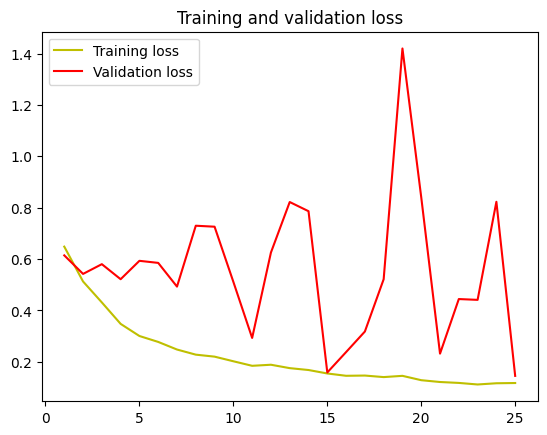

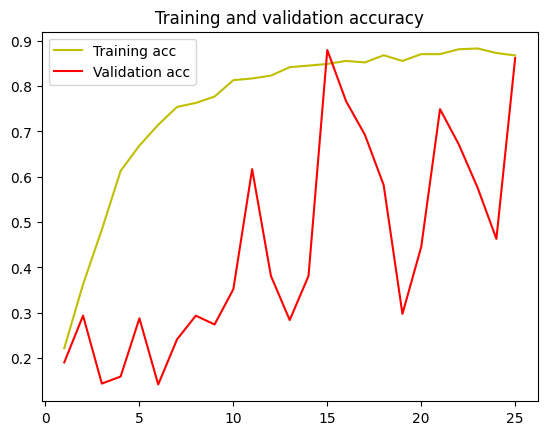

In [ ]:
# Mostramos las gráficas del entrenamiento y validación.
# Vamos a evaluarlos con el set de test al final.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Mostramos las métricas de desempeño del modelo.

# Predicciones
pred_train = model.predict(X_train)
pred_val   = model.predict(X_val)
pred_test  = model.predict(X_test)

# R2
r2_train = r2_score(Y_train, pred_train)
r2_val   = r2_score(Y_val, pred_val)
r2_test  = r2_score(Y_test, pred_test)

# MSE
mse_train = mean_squared_error(Y_train, pred_train)
mse_val   = mean_squared_error(Y_val, pred_val)
mse_test  = mean_squared_error(Y_test, pred_test)

# BIAS
bias_train = np.mean(Y_train - pred_train)
bias_val   = np.mean(Y_val - pred_val)
bias_test  = np.mean(Y_test - pred_test)

# Varianza del error
var_train = np.var(Y_train - pred_train)
var_val   = np.var(Y_val - pred_val)
var_test  = np.var(Y_test - pred_test)

# ===========================
# MOSTRAR TODO
# ===========================

print("Train:")
print("R2:", r2_train)
print("MSE:", mse_train)
print("Bias:", bias_train)
print("Varianza:", var_train)

print("\nValidation:")
print("R2:", r2_val)
print("MSE:", mse_val)
print("Bias:", bias_val)
print("Varianza:", var_val)

print("\nTest:")
print("R2:", r2_test)
print("MSE:", mse_test)
print("Bias:", bias_test)
print("Varianza:", var_test)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Train:
R2: 0.8482921719551086
MSE: 0.023362284526228905
Bias: 0.006310885564250547
Varianza: 0.02332246692901153

Validation:
R2: 0.7687687277793884
MSE: 0.035654760897159576
Bias: 0.007037037237076242
Varianza: 0.035605251114556216

Test:
R2: 0.8443064093589783
MSE: 0.023497842252254486
Bias: 0.0068862254695935985
Varianza: 0.023450425515292538


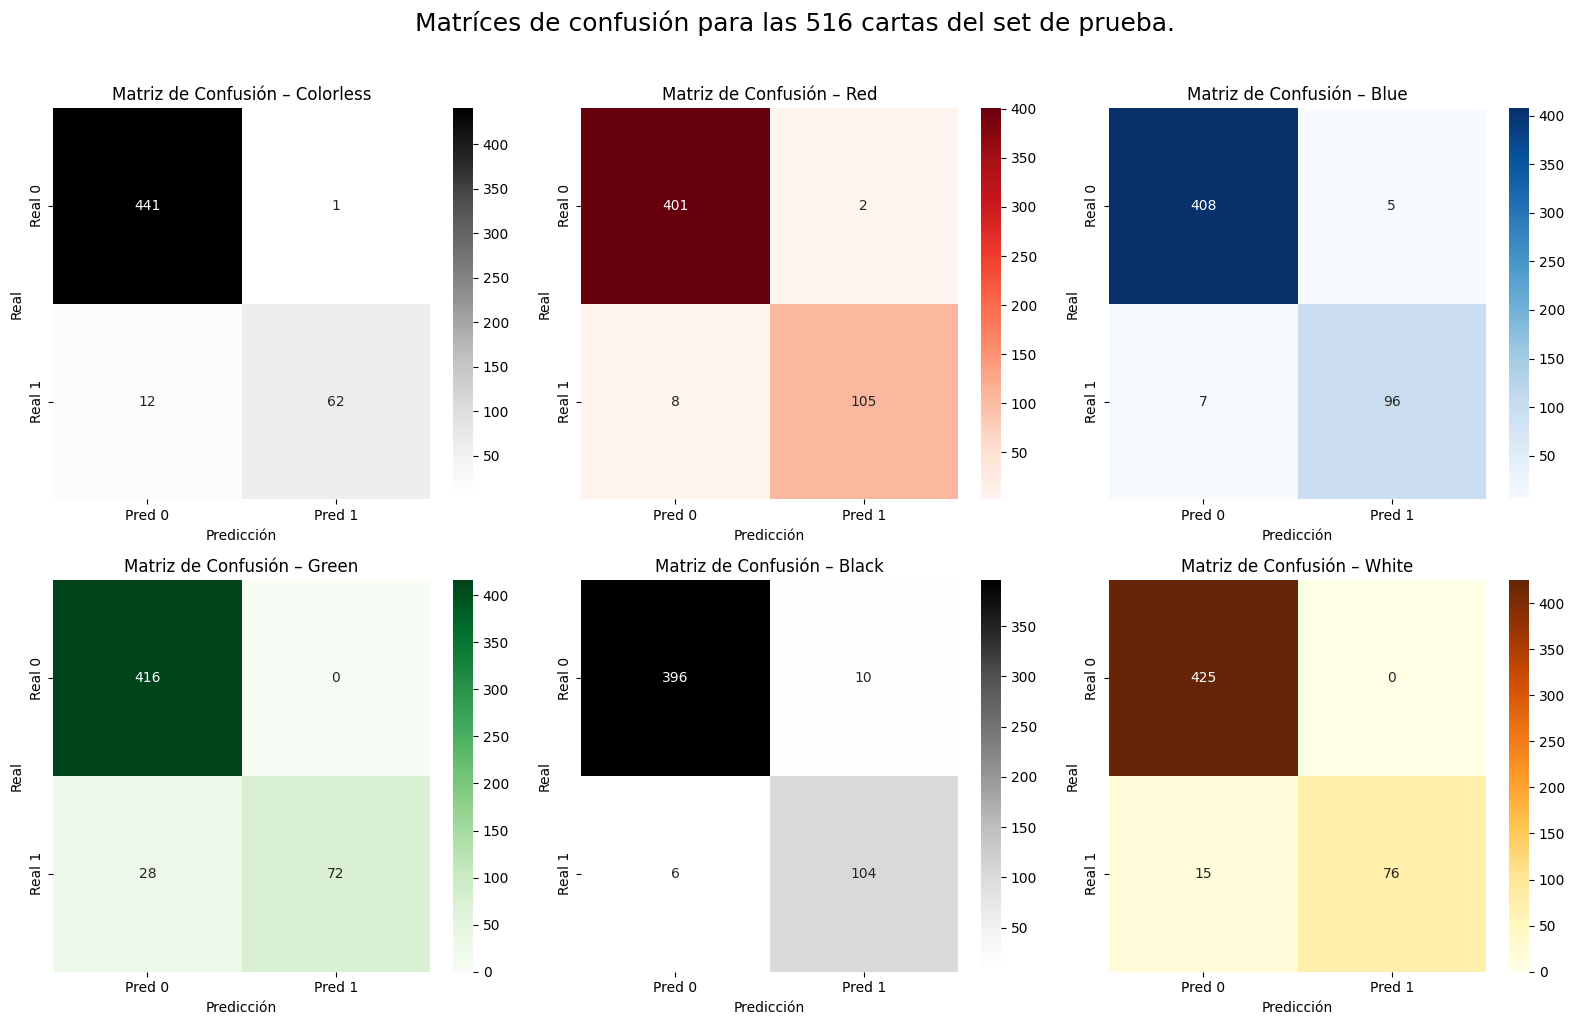

In [ ]:
# Desplegamos matríces de confusión para observar los aciertos de cada color.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Etiquetas de colores
labels = ["Colorless", "Red", "Blue", "Green", "Black", "White"]

# Predicciones binarias con el nivel de confianza mínima establecido (0.6)
pred_test_bin = (pred_test >= 0.6).astype(int)

# Paletas personalizadas para cada color
colormaps = {
    "Colorless": "Greys",
    "Red": "Reds",
    "Blue": "Blues",
    "Green": "Greens",
    "Black": "Greys",
    "White": "YlOrBr"
}

plt.figure(figsize=(16, 10))

for i, label in enumerate(labels):
    cm = confusion_matrix(Y_test[:, i], pred_test_bin[:, i])

    plt.subplot(2, 3, i + 1)
    sns.heatmap(
        cm, annot=True, fmt="d",
        cmap=colormaps[label],
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["Real 0", "Real 1"],
        cbar=True
    )

    plt.title(f"Matriz de Confusión – {label}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")

num_test = len(X_test)
plt.suptitle(f"Matríces de confusión para las {num_test} cartas del set de prueba.", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


# Se generan 5 imágenes aleatorias del conjunto de train para visualizar resultados de predicciones del modelo. Correr varias veces para obtener 5 diferentes resultados.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


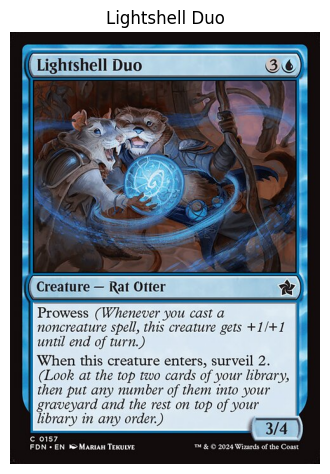


Imagen 486 
Carta: Lightshell Duo

Real:
  🔘 Colorless: 0
  🔴 Red: 0
  🔵 Blue: 1
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.00
  🔴 Red: 0.00
  🔵 Blue: 1.00
  🟢 Green: 0.00
  ⚫ Black: 0.00
  ⚪ White: 0.00

Tu carta es azul.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


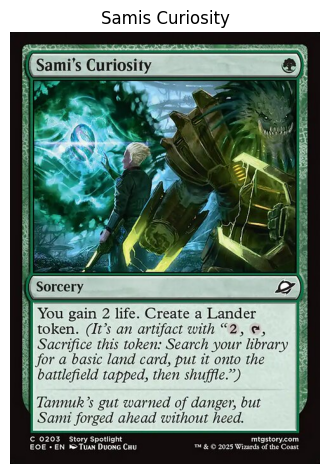


Imagen 208 
Carta: Samis Curiosity

Real:
  🔘 Colorless: 0
  🔴 Red: 0
  🔵 Blue: 0
  🟢 Green: 1
  ⚫ Black: 0
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.00
  🔴 Red: 0.00
  🔵 Blue: 0.00
  🟢 Green: 0.99
  ⚫ Black: 0.01
  ⚪ White: 0.00

Tu carta es verde.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


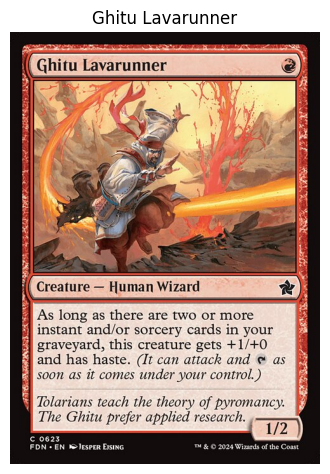


Imagen 412 
Carta: Ghitu Lavarunner

Real:
  🔘 Colorless: 0
  🔴 Red: 1
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.00
  🔴 Red: 1.00
  🔵 Blue: 0.00
  🟢 Green: 0.00
  ⚫ Black: 0.00
  ⚪ White: 0.00

Tu carta es roja.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


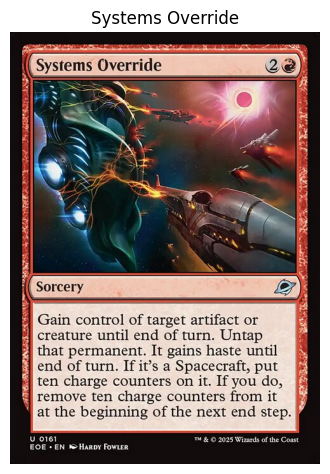


Imagen 15 
Carta: Systems Override

Real:
  🔘 Colorless: 0
  🔴 Red: 1
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.00
  🔴 Red: 1.00
  🔵 Blue: 0.00
  🟢 Green: 0.00
  ⚫ Black: 0.00
  ⚪ White: 0.00

Tu carta es roja.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


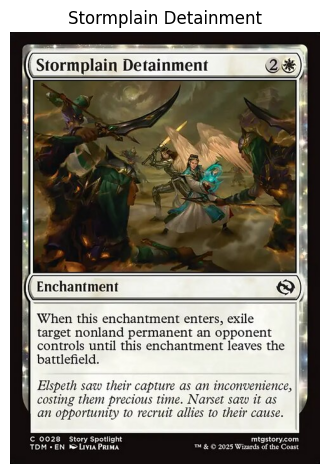


Imagen 138 
Carta: Stormplain Detainment

Real:
  🔘 Colorless: 0
  🔴 Red: 0
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 1

Predicción:
  🔘 Colorless: 0.38
  🔴 Red: 0.00
  🔵 Blue: 0.00
  🟢 Green: 0.00
  ⚫ Black: 0.00
  ⚪ White: 0.78

Tu carta es blanca.


In [ ]:
# Generamos las etiquetas de colores para visualizar resultados.
color_labels = [
    ("Colorless", "🔘"),
    ("Red", "🔴"),
    ("Blue", "🔵"),
    ("Green", "🟢"),
    ("Black", "⚫"),
    ("White", "⚪")
]

# Definimos la cantidad de cartas que queremos mostrar.
num_examples = 5
# Usamos los índices originales de las cartas que guardamos antes.
indices = np.random.choice(len(X_test), num_examples, replace=False)

for idx in indices:

    # Predicción
    pred = model.predict(X_test[idx:idx+1])[0]
    true = Y_test[idx]

    # índice con el nombre de la carta
    idx_real = idx_test[idx]
    card_name = df.iloc[idx_real]['name']

    # Cargar imagen de la carta.
    img_path = os.path.join(card_directory, card_name + ".jpg")
    img_original = cv2.imread(img_path)

    # Mostrar imagen redimensionada.
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,6))
    plt.imshow(img_original)
    plt.title(card_name)
    plt.axis('off')
    plt.show()

    # Texto
    print(f"\nImagen {idx} ")
    print("Carta:", card_name)

    print("\nReal:")
    for (label, emoji), val in zip(color_labels, true):
        print(f"  {emoji} {label}: {val}")

    print("\nPredicción:")
    for (label, emoji), p in zip(color_labels, pred):
        print(f"  {emoji} {label}: {p:.2f}")

    # Mostrar el texto que indica el color de la carta:
    threshold = 0.60
    colores_detectados = []

    for (label, emoji), val in zip(color_labels, pred):
        if val >= threshold:
            colores_detectados.append(label)

    # Generar texto de predicción de la carta.
    if len(colores_detectados) == 0:
        print("\nNo se detectó ningún color con confianza suficiente.")
    else:
        traduccion = {
            "Colorless": "incolora",
            "Red": "roja",
            "Blue": "azul",
            "Green": "verde",
            "Black": "negra",
            "White": "blanca"
        }

        colores_texto = [traduccion[c] for c in colores_detectados]

        if len(colores_texto) == 1:
            frase = f"Tu carta es {colores_texto[0]}."
        else:
            frase = "Tu carta es " + " y ".join(colores_texto) + "."

        print("\n" + frase)


# Elección de carta.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


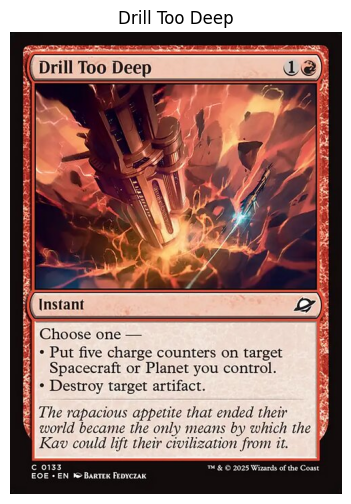

Carta: Drill Too Deep

Real:
  🔘 Colorless: 0
  🔴 Red: 1
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.00
  🔴 Red: 1.00
  🔵 Blue: 0.00
  🟢 Green: 0.00
  ⚫ Black: 0.00
  ⚪ White: 0.00

Tu carta es roja.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Usamos la lista de cartas que definimos en el primer dataframe.
# Sin embargo, se utilizarán los índices definidos después.
card_names = list(df['name'].values)

# Usamos el widget de ipwidgets:
search = widgets.Combobox(
    placeholder='Escribe el nombre de la carta: ',
    options=card_names,
    description='Carta:',
    ensure_option=True,
    layout=widgets.Layout(width='400px')
)

# Mostramos el widget
button = widgets.Button(
    description='Mostrar',
    button_style='success',
    layout=widgets.Layout(width='120px')
)

box = widgets.HBox([search, button])
display(box)


# Desplegamos la carta con el mismo código de antes.
def mostrar_carta(carta):
    clear_output(wait=True)
    display(box)

    if carta not in card_names:
        print("Carta no encontrada")
        return

    # Obtener el índicie original de la carta.
    idx_real = df.index[df['name'] == carta].tolist()[0]

    # Extrar el índice original de la carta.
    img_array = X[idx_real] # Imagen correcta
    true_vals = Y[idx_real] # Etiquetas correctas

    # Predicción con el modelo.
    pred = model.predict(img_array.reshape(1, *img_array.shape))[0]

    # Cargamos la imágen original.
    img_path = os.path.join(card_directory, carta + ".jpg")
    img_original = cv2.imread(img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # Mostrar imágen usando MatPlotLib
    plt.figure(figsize=(5,6))
    plt.imshow(img_original)
    plt.title(carta)
    plt.axis('off')
    plt.show()

    # Mostrar resultados
    print(f"Carta: {carta}\n")

    print("Real:")
    for (label, emoji), val in zip(color_labels, true_vals):
        print(f"  {emoji} {label}: {val}")

    print("\nPredicción:")
    for (label, emoji), val in zip(color_labels, pred):
        print(f"  {emoji} {label}: {val:.2f}")

    # Mostrar el texto que indica el color de la carta:
    threshold = 0.60
    colores_detectados = []

    for (label, emoji), val in zip(color_labels, pred):
        if val >= threshold:
            colores_detectados.append(label)

    # Generar el texto de muestreo de la carta.
    if len(colores_detectados) == 0:
        print("\nNo se detectó ningún color con confianza suficiente.")
    else:
        traduccion = {
            "Colorless": "incolora",
            "Red": "roja",
            "Blue": "azul",
            "Green": "verde",
            "Black": "negra",
            "White": "blanca"
        }

        colores_texto = [traduccion[c] for c in colores_detectados]

        if len(colores_texto) == 1:
            frase = f"Tu carta es {colores_texto[0]}."
        else:
            frase = "Tu carta es " + " y ".join(colores_texto) + "."

        print("\n" + frase)


# Conectamos el botón al widget.
def on_button_clicked(b):
    carta = search.value
    mostrar_carta(carta)

button.on_click(on_button_clicked)

# Exportamos el modelo para utilizar en otros códigos.

In [ ]:
from google.colab import files
model.save("mtg_color_classifier.keras")
files.download("mtg_color_classifier.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>